In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")


### Problem 1: Use pretrained Bert Tokenizer

In [79]:
from transformers import BertTokenizer, BertModel
tokenizer = BertTokenizer.from_pretrained("microsoft/MiniLM-L12-H384-uncased")

tokenizer('toxic')

{'input_ids': [101, 11704, 102], 'token_type_ids': [0, 0, 0], 'attention_mask': [1, 1, 1]}

### Problem 2: Customize prompts and verbalizer

In [ ]:
class ToxicPVP(PVP):
    VERBALIZER_0 = {
        "0": ["polite", "good"],
        "1": ["rude", "bad"]
    }
    
    VERBALIZER_1 = {
        "0": ["like"],
        "1": ["hate"]
    }

    VERBALIZER_2 = {
        "0": ["False"],
        "1": ["True"]
    }
    
    VERBALIZER_3 = {
        "0": ["No"],
        "1": ["Yes"]
    }
    
    VERBALIZER_4 = {
        "0": ["Yes"],
        "1": ["No"]
    }
    
    def get_parts(self, example: InputExample) -> FilledPattern:
        text = self.shortenable(example.text_a)

        if self.pattern_id == 0:
            return [text, 'In summary, the words are', self.mask, '.'], []
        elif self.pattern_id == 1:
            return [text, 'I', self.mask, 'what he said.'],[]
        elif self.pattern_id == 2:
            return [text, 'His statement was', self.mask, '.'],[]
        elif self.pattern_id == 3:
            return [text, 'All in all, the language was', self.mask, '.'],[]
        elif self.pattern_id == 4:
            return [text, 'Question: Is the language toxic? Answer:', self.mask, '.'],[]
        elif self.pattern_id == 5:
            return [text, 'Question: Do you like what he said? Answer:', self.mask, '.'],[]
        elif self.pattern_id == 6:
            return [text, 'Question: Is the man rude? Answer:', self.mask, '.'],[]
        elif self.pattern_id == 7:
            return [text, 'I think the way he talked was', self.mask, '.'],[]
        elif self.pattern_id == 8:
            return ['I', self.mask, 'the following sentences.', text],[]
        elif self.pattern_id == 9:
            return [text,'Based on this, I thought the man was', self.mask, '.'],[]
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        if self.pattern_id == 0 or self.pattern_id == 2 or self.pattern_id == 3 or self.pattern_id == 7 or self.pattern_id == 9:            
            return ToxicPVP.VERBALIZER_0[label]
        elif self.pattern_id == 1 or self.pattern_id == 8:
            return ToxicPVP.VERBALIZER_1[label]
        elif self.pattern_id == 4:
            return ToxicPVP.VERBALIZER_2[label]
        elif self.pattern_id == 5:
            return ToxicPVP.VERBALIZER_4[label]
        elif self.pattern_id == 6:
            return ToxicPVP.VERBALIZER_3[label]


In [70]:
# Also we need to customize the processor

class ToxicPVP(PVP):
    VERBALIZER = {
        "0": ["bad"],
        "1": ["good"]
    }

    def get_parts(self, example: InputExample) -> FilledPattern:
        text = self.shortenable(example.text_a)

        if self.pattern_id == 0:
            return ['It was', self.mask, '.', text], []
        elif self.pattern_id == 1:
            return [text, '. All in all, it was', self.mask, '.'], []
        elif self.pattern_id == 2:
            return ['Just', self.mask, "!"], [text]
        elif self.pattern_id == 3:
            return [text], ['In summary, the statement is', self.mask, '.']
        else:
            raise ValueError("No pattern implemented for id {}".format(self.pattern_id))

    def verbalize(self, label) -> List[str]:
        return ToxicPVP.VERBALIZER[label]

### Problem 3 Use trainer (See a seperate file named 'HW4_baseline.ipynb')

### Problem 4: Train Pet with different number of instances

In [149]:
# randomly pick the sub-sumple of the train data and instore

for num in [10, 50, 100, 500]:
    new_train = train.sample(n=num)
    # to ensure both classes existed in the sub-sumple
    state = (0 in new_train['toxic'].tolist()) and (1 in new_train['toxic'].tolist())
    while not state:
        new_train = train.sample(n=num)
        state = (0 in new_train['toxic'].tolist()) and (1 in new_train['toxic'].tolist())
        
    new_train.to_csv("hw4_train_" + str(num) + '.csv', index=False)

In [150]:
# Use the command line
%run cli.py \
--method pet \
--pattern_ids 0 1 2 3 4 5 6 7 8 9 \
--data_dir "/content" \
--model_type bert \
--model_name_or_path "microsoft/MiniLM-L12-H384-uncased" \
--task_name toxic \
--output_dir "/content/record_500" \
--do_train \
--do_eval \
--pet_per_gpu_eval_batch_size 16 \
--pet_per_gpu_train_batch_size 16 \
--pet_gradient_accumulation_steps 16 \
--pet_max_steps 250 \
--pet_max_seq_length 256 \
--pet_repetitions 1

In [10]:
# all the results were trained by using colab, here I just report the final f1-macro
result = pd.read_csv('result.csv')
result

,F1-Macro,Group
0,0.862263,Regular Classifier
1,0.482542,10 instances
2,0.636772,50
3,0.707032,100
4,0.770668,500


### Problem 5: Plot the comparison of the results

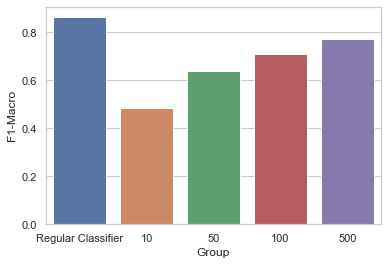

In [14]:
result.loc[1, 'Group'] = '10'
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Group", y="F1-Macro", data=result)
ax.figure.savefig('result.png')